In this excerise we will try to predict if a customer will subscribe to a term deposit , when is called from a call center.
The details of the dataset can be found here. [Portugese bank marketing dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

Attribute Information:

Input variables:
#### Bank client data:
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### Other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)


Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [15]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.rc("font", size=14)

### 1. Read the dataset & drop columns with NA values.


In [16]:
data = pd.read_csv('data/org_banking.txt', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


### 2. Data conversion.
We will convert basic education of different types into one type.This should reduce the cardinality of `education` feature.

In [17]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [18]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [19]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Percentage of subscription", pct_of_sub*100)

Percentage of no subscription is 88.73458288821988
Percentage of subscription 11.265417111780131


### 3. Quick preview of the data.
The data that we have indeed has a lot of string values and we will have to convert them to numreical values.
This can be done using Onehotencoding.


In [20]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


#### 4. Remove co-linear features
It is always a good idea to remove the co-linear feautures. The following code snippet removes co-linear features.

In [21]:
# Create correlation matrix
corr_matrix = data.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# Drop features 
data.drop(data[to_drop], axis=1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,5099.1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,222,1,999,0,nonexistent,1.4,94.465,-41.8,5228.1,0
41184,31,housemaid,married,Basic,unknown,no,no,telephone,may,thu,196,2,999,0,nonexistent,1.1,93.994,-36.4,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,62,3,999,0,nonexistent,1.1,93.994,-36.4,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,200,2,999,0,nonexistent,-3.4,92.431,-26.9,5017.5,0


### 5. Split the data in test and train.

In [35]:
y = data.y.values
X = data.drop(columns=['y'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.4)

### 6. Train a Logistic Regression.

In [36]:
#Train and Logistic Regression:
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler,scale


lr_ohe = OneHotEncoder(handle_unknown='ignore')
lr_scaler = StandardScaler(with_mean=False)
lr_clf = LogisticRegression(max_iter=2500)

pipeline = make_pipeline(lr_ohe,lr_scaler,lr_clf)
pipeline.fit(X_train, y_train)

print(f'Logistic regression train accuracy  :{accuracy_score(y_train,pipeline.predict(X_train))}')
print(f'Logistic regression test accuracy  :{accuracy_score(y_test,pipeline.predict(X_test))}')

Logistic regression train accuracy  :0.9431854969245711
Logistic regression test accuracy  :0.9004005826656956


### Excersise 
7.1 Train a RandomForestClassifier Model and Compare the results.

Which model will you recommend to the business and why?

In [41]:
# Create a OneHotEncoder 
rf_ohe = OneHotEncoder(handle_unknown='ignore')
# Create a RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100,random_state=73)
# Creae a pipeline.
rf_pipeline = make_pipeline(rf_ohe,rf_clf)
# Fit the pipeline.
rf_pipeline.fit(X_train, y_train)
# Calculate the Training and Testing accuracy.

print(f'RF train accuracy  :{accuracy_score(y_train,rf_pipeline.predict(X_train))}')
print(f'RF test accuracy  :{accuracy_score(y_test,rf_pipeline.predict(X_test))}')

RF train accuracy  :1.0
RF test accuracy  :0.90052197135227


7.2 What factors influnce the most in deciding if a person will buy the subscription or not  ?

Hint : Feature importance in RandomForest.

What wolud be your recommendation to the business?

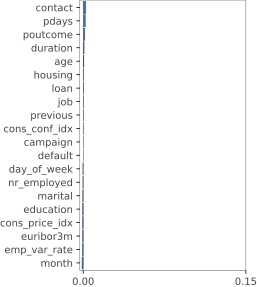

In [45]:
from rfpimp import *
# Calculate the feature importances.
I = importances(rf_pipeline,pd.DataFrame(X_test),pd.DataFrame(y_test),n_samples=-1,sort=True)
plot_importances(I, color='#4575b4')

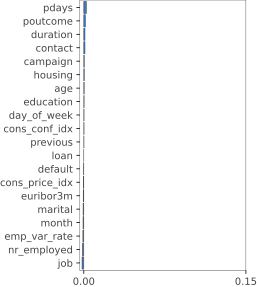

In [46]:
from rfpimp import *
# Calculate the feature importances.
I = importances(rf_pipeline,pd.DataFrame(X_test),pd.DataFrame(y_test),n_samples=-1,sort=True)
plot_importances(I, color='#4575b4')